# TC.L.ITF.1.2.2.1 Compute Cluster-Networks Integration Test

[Jama link](https://skaoffice.jamacloud.com/perspective.req#/testCases/1004576?projectId=335])

> This test case checks for correct integration of the software running in Kubernetes Pods in the LOW ITF computing platform with the NSDN and SDN for access to control and monitor LOW telescope hardware components. The common deployment platform allows us to define a single test case checking IP connectivity and protocols which can be used by all software components. This verifies the correct configuration of networking hardware (switches, firewalls, cabling, connectors), network configuration of the compute cluster nodes, and Kubernetes networking components that allow Pods to communicate on the NSDN. The test script will be parameterised with the ports and protocols that are used by LOW telescope hardware components. 

The test computer we will use is one of the sITF's subrack management boards. As a real piece of telescope equipment on the NSDN, this is a highly effective test of our cluster's ability to access NSDN-connected devices. 

In [ ]:
# pragma pylint: disable=line-too-long
# pragma pylint: disable=import-error
# pragma pylint: disable=consider-using-with

In [ ]:
import json
import subprocess
import time

import configuration  # Python packages for configuration capture on the cluster
import display
from kubernetes import client, config

subrack_ip_address = "10.135.155.132"

## Config capture

In [ ]:
charts = configuration.get_charts()
pods = configuration.get_pods()
tango_config = configuration.get_tango_config()

print("CHARTS")
display.as_json_tree(charts)
print("\nPODS")
display.as_json_tree(pods)
print("\nTANGO CONFIGURATION")
display.as_json_tree(tango_config)

## Test subrack web server on port 8081
For this test, we just use the existing web server that is running on the subrack management board. If we update this test to use a different test device, we will need to incorporate this test into the generic port/protocol tests below.

In [ ]:
stdout = !curl -q 'http://{subrack_ip_address}:8081/get/json.htm?type=getattribute&param=tpm_powers' 2>/dev/null

In [ ]:
assert len(stdout) == 1
print(stdout[0])
assert json.loads(stdout[0])["status"] == "OK"

## Test other protocols/ports on the NSDN

Here we use iperf3 on the subrack management board and in this notebook to transfer data on a selection of endpoints of interest, simulating telescope hardware.

In [ ]:
endpoints = [
    {
        "udp": True,
        "inbound": True,
        "port": 10000,
    },  # UCP control protocol for TPMs
    {"udp": True, "inbound": False, "port": 4660},  # SPEAD data out from TPMs
    {
        "udp": False,
        "inbound": True,
        "port": 8080,
    },  # an arbitrary TCP connection
]

In [ ]:
!conda install -yq iperf

In [ ]:
for endpoint in endpoints:
    udp = "--udp --bitrate 10M" if endpoint["udp"] else ""
    sport = f"--port {endpoint['port']}" if endpoint["inbound"] else ""
    cport = "" if endpoint["inbound"] else f"--reverse --cport {endpoint['port']}"

    # SSH to the subrack and start iperf3 in server mode in the background
    command = f"ssh mnguser@{subrack_ip_address} iperf3 --server --one-off {sport}"
    subp = subprocess.Popen(command.strip().split(), stdout=subprocess.DEVNULL)
    time.sleep(1)

    # start iperf3 in this notebook server and connect to the subrack
    result = !iperf3 --client {subrack_ip_address} --time 5 {udp} {sport} {cport}

    client_result = "\n".join(result)
    print(f"{endpoint}")
    print(client_result)
    # print(f"Summary: {client_result['end']['sum_sent']['bits_per_second']/1000/1000:.2f}Mbps")
    print()

## Test the cluster's connection to the Science Data Network

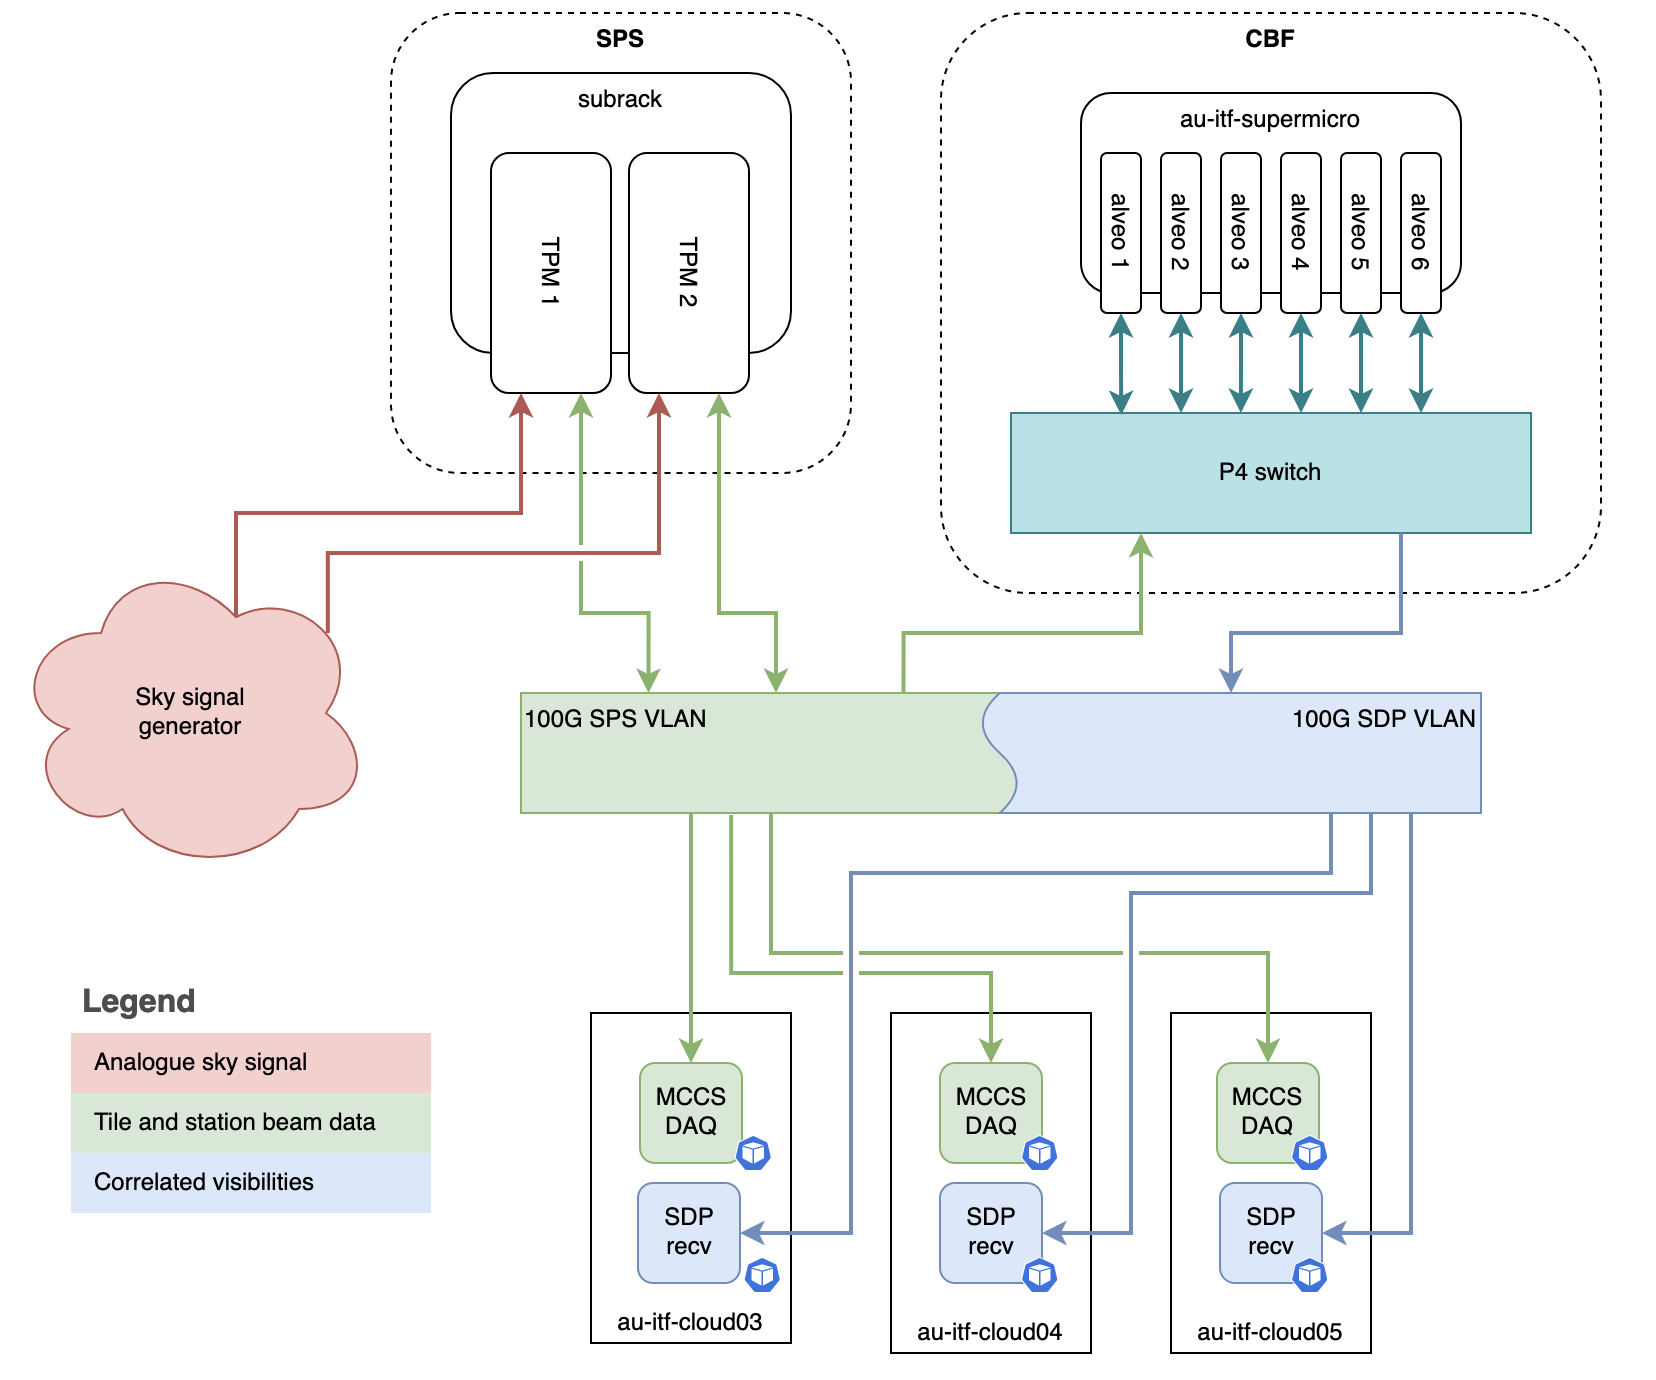

We use iperf3 and our SDN NetworkAttachmentDefinition pods to test that our cluster servers are correctly configured to communicate on the 100G science data network on both SPS and SDP VLANs indicated in green and blue in the diagram above. First we get an API client object and define a function to create iperf3 Pod manifests.

In [ ]:
# Configs can be set in Configuration class directly or using helper utility
config.load_incluster_config()
v1 = client.CoreV1Api()


def create_iperf3_pod(suffix, node, networks, endpoint=None):
    return {
        "apiVersion": "v1",
        "kind": "Pod",
        "metadata": {
            "name": f"iperf-test-pod-{suffix}",
            "annotations": (
                {
                    "k8s.v1.cni.cncf.io/networks": networks,
                }
                if networks
                else {}
            ),
        },
        "spec": {
            "containers": [
                {
                    "name": "iperf3",
                    "image": "networkstatic/iperf3",
                    "args": ["-c", endpoint] if endpoint else ["-s"],
                }
            ],
            "nodeName": node,
            "restartPolicy": "Never",
        },
    }

This is the NetworkAttachmentDefinition that defines a link to the 100G SPS network. Pods that are annotated correctly with this will be created with an extra network interface on the SDN.

Here we create an iperf3 server Pod, wait for it to be Running, and then read the IP address of its SDN interface.

In [ ]:
server_pod = v1.create_namespaced_pod(
    "test-environment",
    create_iperf3_pod(
        "server",
        "au-itf-cloud05",
        json.dumps(
            [
                {"namespace": "kube-system", "name": "low-itf-sdn-sps"},
                {
                    "name": "low-itf-sdn-sdp",
                    "namespace": "kube-system",
                    "ips": ["10.0.0.1/24"],
                },
            ]
        ),
    ),
)

while server_pod.status.phase != "Running":
    time.sleep(1)
    server_pod = v1.read_namespaced_pod(server_pod.metadata.name, "test-environment")


display.as_json_tree(server_pod.to_dict())

networks = json.loads(
    server_pod.metadata.annotations["k8s.v1.cni.cncf.io/networks-status"]
)
ips = {n["name"]: n["ips"][0] for n in networks if n["name"].startswith("kube-system/")}
print(ips)

Create an iperf3 client Pod, pointing at the IP we just retrieved from the server, and wait for it to complete.

In [ ]:
sps_client_pod = v1.create_namespaced_pod(
    "test-environment",
    create_iperf3_pod(
        "client-sps",
        "au-itf-cloud04",
        "kube-system/low-itf-sdn-sps",
        ips["kube-system/low-itf-sdn-sps"],
    ),
)

while sps_client_pod.status.phase != "Running":
    time.sleep(1)
    sps_client_pod = v1.read_namespaced_pod(
        sps_client_pod.metadata.name, "test-environment"
    )

display.as_json_tree(sps_client_pod.to_dict())

while sps_client_pod.status.phase == "Running":
    time.sleep(1)
    sps_client_pod = v1.read_namespaced_pod(
        sps_client_pod.metadata.name, "test-environment"
    )

print("Complete")

Read the client Pod log, which will give us some statistics about the test transfer. We should not expect to see line rate here - iperf3 is single-threaded, and struggles to push 100G without parallelism and extra tuning. Any bitrate above 10 Gbits/sec must be taking place over the 100G network. 

In [ ]:
print(v1.read_namespaced_pod_log(sps_client_pod.metadata.name, "test-environment"))

In [ ]:
sdp_client_pod = v1.create_namespaced_pod(
    "test-environment",
    create_iperf3_pod(
        "client-sdp",
        "au-itf-cloud03",
        json.dumps(
            [
                {
                    "name": "low-itf-sdn-sdp",
                    "namespace": "kube-system",
                    "ips": ["10.0.0.2/24"],
                }
            ]
        ),
        ips["kube-system/low-itf-sdn-sdp"],
    ),
)

while sdp_client_pod.status.phase != "Running":
    time.sleep(1)
    sdp_client_pod = v1.read_namespaced_pod(
        sdp_client_pod.metadata.name, "test-environment"
    )

display.as_json_tree(sdp_client_pod.to_dict())

while sdp_client_pod.status.phase == "Running":
    time.sleep(1)
    sdp_client_pod = v1.read_namespaced_pod(
        sdp_client_pod.metadata.name, "test-environment"
    )

print(sdp_client_pod.status.phase)

Read the client Pod log, which will give us some statistics about the test transfer. We should not expect to see line rate here - iperf3 is single-threaded, and struggles to push 100G without parallelism and extra tuning. Any bitrate above 10 Gbits/sec must be taking place over the 100G network. 

In [ ]:
print(v1.read_namespaced_pod_log(sdp_client_pod.metadata.name, "test-environment"))

Delete our test pods:

In [ ]:
for pod in [sdp_client_pod, sps_client_pod, server_pod]:
    v1.delete_namespaced_pod(pod.metadata.name, "test-environment")